In [71]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from matplotlib.ticker import AutoMinorLocator
import matplotlib.dates as mdates
from sunpy.net import Fido, attrs as a
from scipy.ndimage import gaussian_filter
import astropy.units as u
from astropy.time import Time
from astropy.visualization import ImageNormalize, PercentileInterval, SqrtStretch, LogStretch, AsinhStretch
from spacepy import pycdf
from radiospectra.spectrogram import Spectrogram

import matplotlib as mpl
mpl.rcParams['date.epoch'] = '1970-01-01T00:00:00'
try:
    mdates.set_epoch('1970-01-01T00:00:00')
except:
    pass

import requests
import os
import sys
repo_dir = '/home/mnedal/repos/dias_work'
# Construct the full path to the scripts directory
script_path = os.path.abspath(f'{repo_dir}/scripts')

# Add the scripts directory to sys.path
if script_path not in sys.path:
    sys.path.append(script_path)

import solar_data_utils as myfuncs
# Reload to update with new changes
import importlib
importlib.reload(myfuncs)

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.format'] = 'png'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

data_dir = '/home/mnedal/data'
os.makedirs(f'{data_dir}/PSP/FIELDS', exist_ok=True)

In [14]:
date = '2021-09-18'

YEAR, MONTH, DAY = date.split('-')

## Load PSP radio data

In [101]:
level = 'l2'

if level == 'l2':
    hfr_filename = f'psp_fld_{level}_rfs_hfr_{YEAR}{MONTH}{DAY}_v02.cdf'
    lfr_filename = f'psp_fld_{level}_rfs_lfr_{YEAR}{MONTH}{DAY}_v02.cdf'
    if not os.path.exists(hfr_filename):
        URL = f'http://research.ssl.berkeley.edu/data/psp/data/sci/fields/{level}/rfs_hfr/{YEAR}/{MONTH}/{hfr_filename}'
        response = requests.get(URL)
        open(f'{data_dir}/PSP/FIELDS/{hfr_filename}', 'wb').write(response.content)
    if not os.path.exists(lfr_filename):
        URL = f'http://research.ssl.berkeley.edu/data/psp/data/sci/fields/{level}/rfs_lfr/{YEAR}/{MONTH}/{lfr_filename}'
        response = requests.get(URL)
        open(f'{data_dir}/PSP/FIELDS/{lfr_filename}', 'wb').write(response.content)

elif level == 'l3':
    hfr_filename = f'psp_fld_{level}_rfs_hfr_{YEAR}{MONTH}{DAY}_v03.cdf'
    lfr_filename = f'psp_fld_{level}_rfs_lfr_{YEAR}{MONTH}{DAY}_v03.cdf'
    if not os.path.exists(hfr_filename):
        URL = f'http://research.ssl.berkeley.edu/data/psp/data/sci/fields/{level}/rfs_hfr/{YEAR}/{MONTH}/{hfr_filename}'
        response = requests.get(URL)
        open(f'{data_dir}/PSP/FIELDS/{hfr_filename}', 'wb').write(response.content)
    if not os.path.exists(lfr_filename):
        URL = f'http://research.ssl.berkeley.edu/data/psp/data/sci/fields/{level}/rfs_lfr/{YEAR}/{MONTH}/{lfr_filename}'
        response = requests.get(URL)
        open(f'{data_dir}/PSP/FIELDS/{lfr_filename}', 'wb').write(response.content)

# load the PSP data
cdf_psp_hfr = pycdf.CDF(f'{data_dir}/PSP/FIELDS/{hfr_filename}')
cdf_psp_lfr = pycdf.CDF(f'{data_dir}/PSP/FIELDS/{lfr_filename}')

tmin_lfr = cdf_psp_lfr['epoch_lfr'].meta['SCALEMIN']
tmax_lfr = cdf_psp_lfr['epoch_lfr'].meta['SCALEMAX']

# convert pixels values to dB, z-axis
arr_lfr = np.array(cdf_psp_lfr.get('psp_fld_l2_rfs_lfr_auto_averages_ch0_V1V2'))

# The min power scaled power spectral density (PSD) of 1e-16 is used as a threshold
# according to Pulupa et al. 2020, https://doi.org/10.3847/1538-4365/ab5dc0
# more info: https://en.wikipedia.org/wiki/Decibel
Lp_lfr = 10*np.log10(arr_lfr/10**-16)

tm_lfr = np.array(cdf_psp_lfr.get('epoch_lfr')) # x-axis
freq_lfr = np.array(cdf_psp_lfr.get('frequency_lfr_auto_averages_ch0_V1V2'))/10**6 # y-axis

tmin_hfr = cdf_psp_hfr['epoch_hfr'].meta['SCALEMIN']
tmax_hfr = cdf_psp_hfr['epoch_hfr'].meta['SCALEMAX']

# convert pixels values to dB, z-axis
arr_hfr = np.array(cdf_psp_hfr.get('psp_fld_l2_rfs_hfr_auto_averages_ch0_V1V2'))
Lp_hfr = 10*np.log10(arr_hfr/10**-16)

tm_hfr = np.array(cdf_psp_hfr.get('epoch_hfr')) # x-axis
freq_hfr = np.array(cdf_psp_hfr.get('frequency_hfr_auto_averages_ch0_V1V2'))/10**6 # y-axis

# clean the dyspec by subtracting the Mean intensity from each freq channel
df_psp_hfr = pd.DataFrame(Lp_hfr.T)
df_psp_lfr = pd.DataFrame(Lp_lfr.T)

df_psp_hfr_mean = df_psp_hfr.mean(axis=1)
df_psp_lfr_mean = df_psp_lfr.mean(axis=1)

# subtract that mean value from each corresponding row
df_psp_hfr = df_psp_hfr.sub(df_psp_hfr_mean, axis=0)
df_psp_lfr = df_psp_lfr.sub(df_psp_hfr_mean, axis=0)

# concat the two arrays of both bands
df_lfr = pd.DataFrame(df_psp_lfr)
df_lfr.insert(loc=0, column='frequency', value=freq_lfr[1])
df_lfr.set_index(['frequency'], inplace=True)

df_hfr = pd.DataFrame(df_psp_hfr)
df_hfr.insert(loc=0, column='frequency', value=freq_hfr[1])
df_hfr.set_index(['frequency'], inplace=True)

# drop the overlapped rows, take only the first row of the duplicated group
df_psp = pd.concat([df_lfr, df_hfr])
df_psp = df_psp.sort_index(axis=0)
df_psp = df_psp[~df_psp.index.duplicated(keep='first')]
df_psp.columns = max([tm_lfr, tm_hfr], key=len)

fields_freqs = df_psp.index.values*u.MHz
fields_times = Time([dt.isoformat() for dt in tm_hfr])

In [102]:
# calculate the mean value in each row (freq channel)
# and subtract it from each corresponding row
df_psp_mean = df_psp.mean(axis=1)
df_psp_submean = df_psp.sub(df_psp_mean, axis=0)

# Apply Gaussian smoothing
smoothed_psp = gaussian_filter(df_psp_submean.values, sigma=1)
df_smoothed_psp = pd.DataFrame(smoothed_psp, index=df_psp.index, columns=df_psp.columns)
psp_submean_norm = ImageNormalize(df_smoothed_psp, interval=PercentileInterval(97), clip=True)

In [105]:
meta = {
    'observatory': 'PSP',
    'instrument': 'FIELDS',
    'detector': 'HFR-LFR',
    'freqs': fields_freqs,
    'wavelength': a.Wavelength(fields_freqs[0], fields_freqs[-1]),
    'times': fields_times,
    'start_time': fields_times[0],
    'end_time': fields_times[-1]
}
psp_dyspec = Spectrogram(df_smoothed_psp.values, meta)

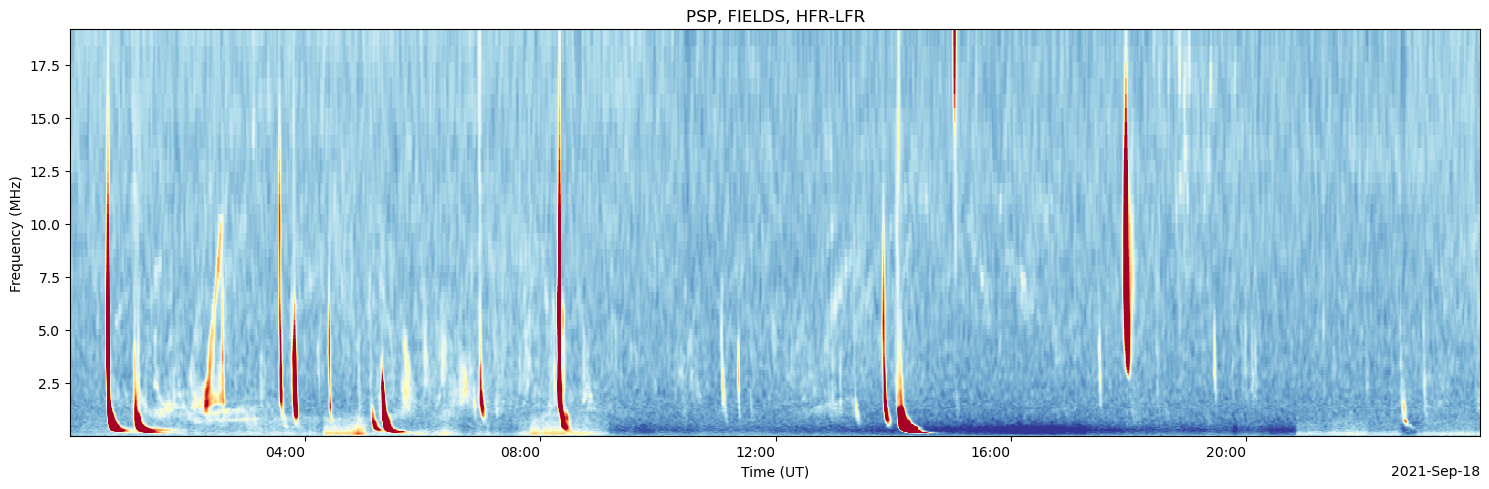

In [107]:
fig = plt.figure(figsize=[15,5])
ax = fig.add_subplot(111)
psp_dyspec.plot(axes=ax,
                norm=psp_submean_norm,
                cmap='RdYlBu_r'
               )
# ax.set_yscale('log')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.tick_params(axis='x', rotation=0)
# ax.set_xlim(left=pd.Timestamp('2021-09-18T07:00'), right=pd.Timestamp('2021-09-18T09:00'))
fig.tight_layout()
# fig.subplots_adjust(left=0.041, bottom=0.096, right=0.984, top=0.93, wspace=0.132, hspace=0.31)
plt.show()